# N170 with Nevis

This experiment consisted in the presentation of face and house images, in order to elicit the N170 potential. 

Stimuli were presented for 200 ms with an intertrial interval of 400 ms and random jitter of ±100ms. The task was to mentally note whether a "face" or a "house" was presented. Six blocks of 2 min were recorded for a single partipant.

The stimuli set consisted in 12 grayscale pictures of centered human faces for the "face" condition, and in 12 grayscale pictures of houses for the "face" condition. The pictures were obtained from:

> Haxby, J., Gobbini, M., Furey, M., Ishai, A., Schouten, J., and Pietrini, P. (2001). 
Distributed and overlapping representations of faces and objects in ventral temporal 
cortex. Science 293, 2425–2430.

In [1]:
import os
import sys
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('../muse')
import utils

## Load data into MNE objects

In [2]:
subject = 1
session = 1
raw = utils.load_data('visual/N170', sfreq=256., 
                      subject_nb=subject, session_nb=session)

Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30720
    Range : 0 ... 30719 =      0.000 ...   119.996 secs
Ready.


## Power Spectrum

Effective window size : 8.000 (s)


/usr/local/lib/python3.5/dist-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


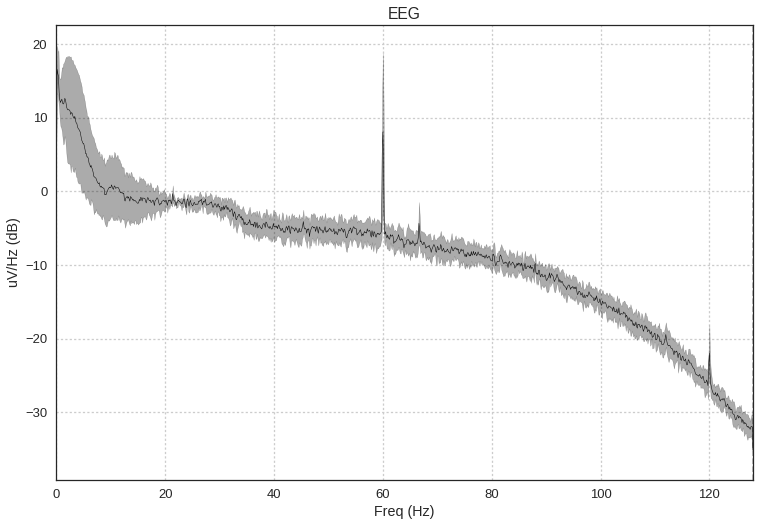

In [3]:
raw.plot_psd(tmax=np.inf);

## Filtering

We filter data between 1 and 30 Hz.

In [4]:
raw.filter(1,30, method='iir')

Setting up band-pass filter from 1 - 30 Hz


<RawArray  |  None, n_channels x n_times : 5 x 184380 (720.2 sec), ~7.0 MB, data loaded>

## Epoching

Here we epoch data for -100ms to 800ms after the stimulus. No baseline correction is needed (signal is bandpass filtered) and we reject every epochs were the signal exceed 75 uV. This mainly rejects blinks.

In [5]:
from mne import Epochs, find_events

events = find_events(raw)
event_id = {'Face': 1, 'House': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 75e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
epochs

1174 events found
Events id: [1 2]


<Epochs  |  n_events : 1127 (all good), tmin : -0.1015625 (s), tmax : 0.80078125 (s), baseline : None, ~8.0 MB, data loaded,
 'Face': 565, 'House': 562>

## Epoch average

Now we can plot the average ERP for both conditions:

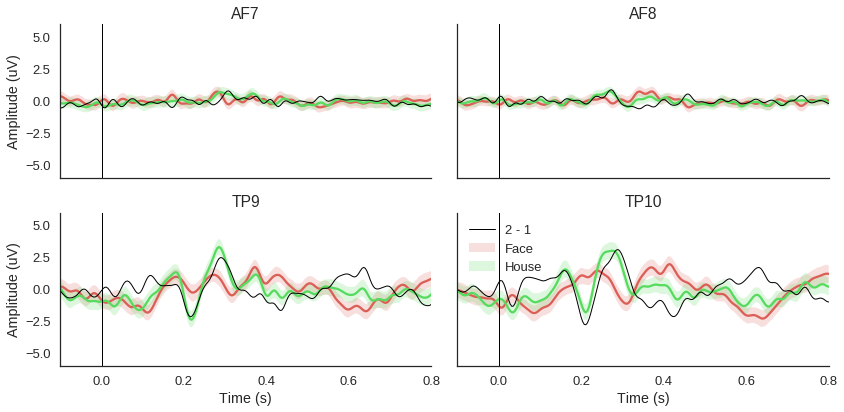

In [6]:
conditions = OrderedDict()
conditions['Face'] = [1]
conditions['House'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2))

A clear N170 around 200 ms can be seen in the difference waveform.

## Decoding

By averaging the epochs, we can clearly identify and ERP. However this does not tell us anything about the SNR of the P300. I like using a classification pipeline to get a sence of the strengh of the P300 response on a single trial basis.

Here is will use 4 different pipelines :
- **Vect + LR** :  Vectorization of the trial + Logistic Regression. This can be considered as the standard decoding pipeline in MEG / EEG.
- **Vect + RegLDA** :  Vectorization of the trial + Regularized LDA. This one is very used in P300 BCI. It can outperform the previous one but can become unusable if the number of dimension is too high.
- **ERPCov + TS**: ErpCovariance + Tangent space mapping. One of my favorite Riemannian geometry based pipeline.
- **ERPCov + MDM**: ErpCovariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.

Evaluation is done in cross-validation, with AUC as metric (AUC is probably the best metric for binary and unbalanced classification problem)

In [7]:
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

from collections import OrderedDict

clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                            random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', 
                              cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

Vect + LR
Vect + RegLDA
ERPCov + TS
ERPCov + MDM
XdawnCov + TS
XdawnCov + MDM


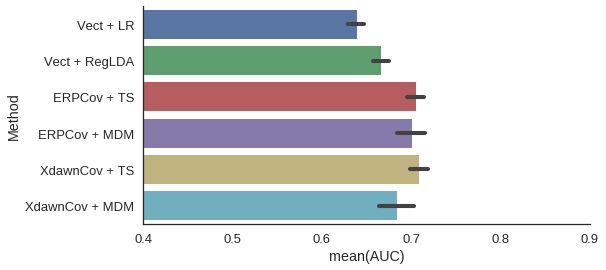

In [8]:
fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 0.9)
sns.despine()